In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from tensorflow import keras
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow import keras
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(1)
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../data/covid-19-nlp-text-classification/Corona_NLP_train.csv', encoding='latin1')
test = pd.read_csv('../data/covid-19-nlp-text-classification/Corona_NLP_test.csv', encoding='latin1')

df = pd.concat([train, test])
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [4]:
df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1, inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


In [5]:
df.drop_duplicates(inplace=True)
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,Did you panic buy a lot of non-perishable item...,Negative
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,Gov need to do somethings instead of biar je r...,Extremely Negative


<Axes: xlabel='Sentiment', ylabel='count'>

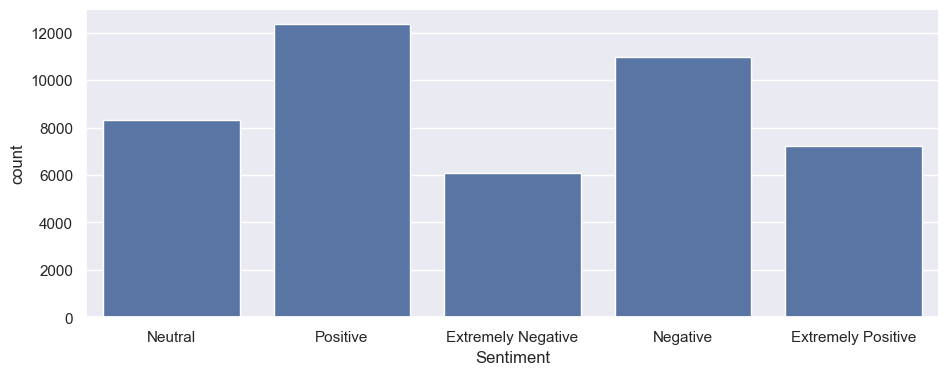

In [6]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(x='Sentiment', data=df)

In [7]:
df['Sentiment'].value_counts()

Sentiment
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: count, dtype: int64

In [8]:
df.replace(['Extremely Negative', 'Extremely Positive','Extremely Pos'], ['Negative', 'Positive','Positive'], inplace=True)
df['Sentiment'].value_counts()

Sentiment
Positive    19592
Negative    17031
Neutral      8332
Name: count, dtype: int64

In [9]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/kale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
import re
import nltk
nltk.download('punkt') # At first you have to download these nltk packages.
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = stopwords.words('english') # defining stop_words
stop_words.remove('not') # removing not from the stop_words list as it contains value in negative movies
lemmatizer = WordNetLemmatizer()

def nlpPreprocessing(tweet):
    # Data cleaning
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#\w+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'<.*?>', '', tweet)  # Remove HTML tags
    tweet = re.sub('[^A-Za-z]+', ' ', tweet)  # Keep only alphabetic characters

    # Convert to lowercase
    tweet = tweet.lower()

    # Tokenization
    tokens = nltk.word_tokenize(tweet)  # Convert text to tokens

    # Remove single-character tokens (except meaningful ones like 'i' and 'a')
    tokens = [word for word in tokens if len(word) > 1]

    # Remove stopwords
    tweet = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tweet = [lemmatizer.lemmatize(word) for word in tweet]

    # Join words back into a single string
    tweet = ' '.join(tweet)

    return tweet

[nltk_data] Downloading package punkt to /Users/kale/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [12]:
df['OriginalTweet'] = df['OriginalTweet'].apply(nlpPreprocessing)
df.head()

,OriginalTweet,Sentiment
0,,Neutral
1,advice talk neighbour family exchange phone nu...,Positive
2,coronavirus australia woolworth give elderly d...,Positive
3,food stock not one empty please panic enough f...,Positive
4,ready go supermarket outbreak not paranoid foo...,Negative


In [13]:
df['Sentiment'] = df['Sentiment'].apply(lambda x: x.lower())
df.head()

,OriginalTweet,Sentiment
0,,neutral
1,advice talk neighbour family exchange phone nu...,positive
2,coronavirus australia woolworth give elderly d...,positive
3,food stock not one empty please panic enough f...,positive
4,ready go supermarket outbreak not paranoid foo...,negative


In [14]:
# !pip install WordCloud

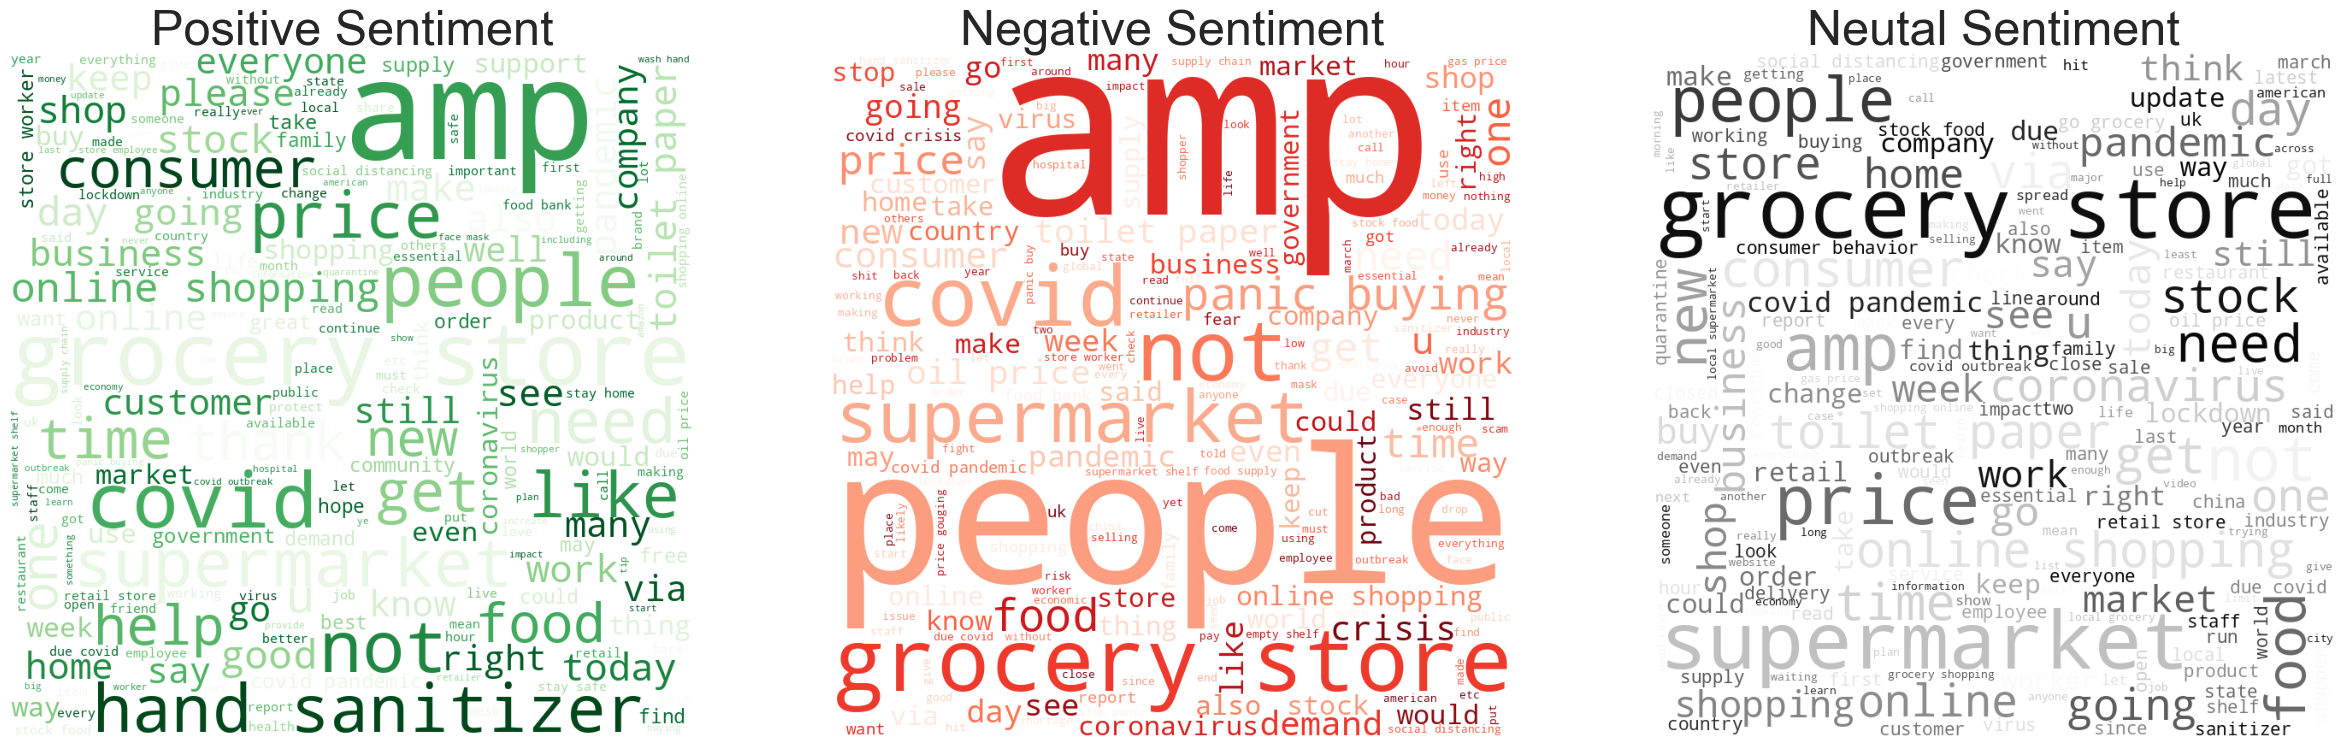

In [15]:
from wordcloud import WordCloud
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["Sentiment"]=="positive"]['OriginalTweet']
df_neg = df[df["Sentiment"]=="negative"]['OriginalTweet']
df_neu = df[df["Sentiment"]=="neutral"]['OriginalTweet']

words_list = df_pos.unique().tolist()
words = " ".join(words_list)
font_path = "/Library/Fonts/Arial.ttf"


wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greens",
                stopwords = stop_words,
                min_font_size = 10).generate(words)

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

words_list = df_neg.unique().tolist()
words = " ".join(words_list)


wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Reds",
                stopwords = stop_words,
                min_font_size = 10).generate(words)
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);

words_list = df_neu.unique().tolist()
words = " ".join(words_list)


wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='white',
                colormap="Greys",
                stopwords = stop_words,
                min_font_size = 10).generate(words)
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

In [16]:
l = {"neutral":0, "positive":1,"negative":2}
df['Sentiment'] = df['Sentiment'].map(l)
df

,OriginalTweet,Sentiment
0,,0
1,advice talk neighbour family exchange phone nu...,1
2,coronavirus australia woolworth give elderly d...,1
3,food stock not one empty please panic enough f...,1
4,ready go supermarket outbreak not paranoid foo...,2
...,...,...
3793,meanwhile supermarket israel people dance sing...,1
3794,panic buy lot non perishable item echo need fo...,2
3795,asst prof economics talking recent research co...,0
3796,gov need somethings instead biar je rakyat ass...,2


In [17]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x = df['OriginalTweet']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
from gensim.models import Word2Vec
tweets = X_train.tolist()
tweets = [tweet.split() for tweet in tweets]
w2v = Word2Vec(tweets, vector_size=200, window=5, workers=7, epochs=100, min_count=5)

In [19]:
print(w2v.wv.most_similar('pay'))

[('paying', 0.4263218343257904), ('paid', 0.3819391131401062), ('salary', 0.32452550530433655), ('qualify', 0.3086674213409424), ('payroll', 0.2941077947616577), ('wage', 0.28662240505218506), ('bonus', 0.2743326723575592), ('wil', 0.2699301242828369), ('benefit', 0.26907047629356384), ('childcare', 0.26510435342788696)]


In [20]:
print(w2v.wv.most_similar('covid'))

[('coronavirus', 0.5900986194610596), ('global', 0.31425726413726807), ('virus', 0.31221604347229004), ('corona', 0.31155094504356384), ('consumer', 0.29474401473999023), ('business', 0.2806051969528198), ('read', 0.2782876193523407), ('help', 0.27611300349235535), ('may', 0.27084994316101074), ('continue', 0.2613224983215332)]


In [21]:
w2v.wv.doesnt_match(['grocery', 'covid', 'coronavirus'])

'grocery'

In [22]:
max_len = np.max(X_train.apply(lambda x :len(x)))
max_len

261

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#creating embedding matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_length = len(tokenizer.word_index) + 1


X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

print(vocab_length)

embedding_dim = 200
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v.wv:
        embedding_matrix[i] = w2v.wv[word]


25210


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout,GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
# Define the model
model = Sequential()

# Embedding layer with the pre-trained Word2Vec weights
model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,  # max length of input sequences
                    trainable=False))


model.add(Bidirectional(LSTM(264, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy'  , metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     5,042,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,042,000 (19.23 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,042,000 (19.23 MB)

In [25]:
num_epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 943s 957ms/step - accuracy: 0.6467 - loss: 1.0245 - val_accuracy: 0.7816 - val_loss: 0.7109
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 968s 984ms/step - accuracy: 0.7984 - loss: 0.6720 - val_accuracy: 0.8086 - val_loss: 0.6533
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1243s 1s/step - accuracy: 0.8357 - loss: 0.5961 - val_accuracy: 0.8209 - val_loss: 0.6484
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1015s 1s/step - accuracy: 0.8561 - loss: 0.5564 - val_accuracy: 0.8236 - val_loss: 0.6763
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1734s 2s/step - accuracy: 0.8757 - loss: 0.5261 - val_accuracy: 0.8289 - val_loss: 0.7063
Epoch 6/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1767s 2s/step - accuracy: 0.8916 - loss: 0.5060 - val_accuracy: 0.8238 - val_loss: 0.7850


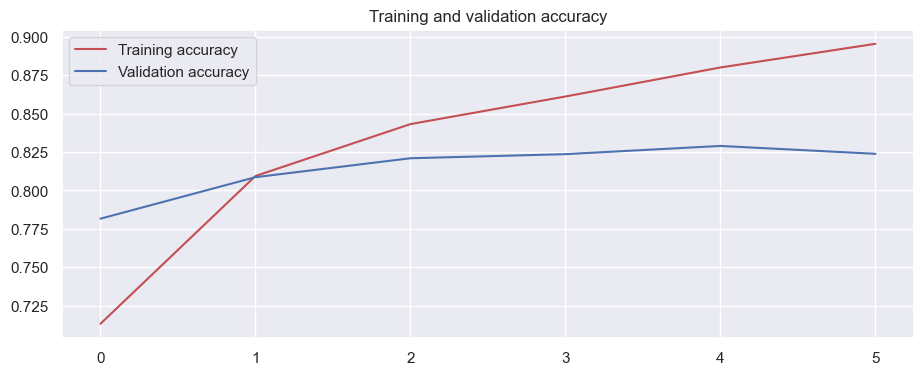

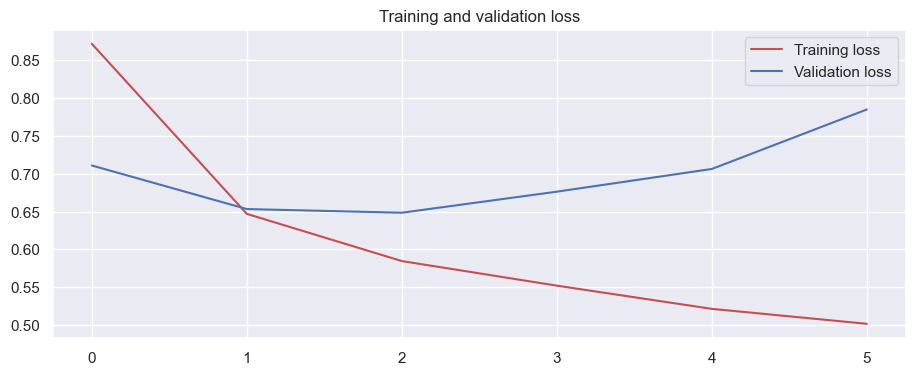

Accuracy on training data is:- 89.53540325164795 %
Loss 50.141072273254395
Accuracy on validation data is:- 82.38303661346436 %
Loss 78.5009503364563


In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

In [27]:
model.save("COVID_NLP4.keras")

In [28]:

joblib.dump(tokenizer, 'tokenizer4.joblib')

['tokenizer4.joblib']

In [32]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
# Load the model
model = load_model('COVID_NLP4.keras')
# Load the model from the specified file
tokenizer = joblib.load('tokenizer4.joblib')

# X_test = tokenizer.texts_to_sequences(X_test)
# X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 483ms/step - accuracy: 0.8213 - loss: 0.6480
Test Loss: 0.6484070420265198
Test Accuracy: 0.8209387063980103


## Allow the embedding layer to modify the word2vec weights 

In [33]:
# Define the model
model = Sequential()

# Embedding layer with the pre-trained Word2Vec weights
model.add(Embedding(input_dim=vocab_length,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,  # max length of input sequences
                    trainable=True))


model.add(Bidirectional(LSTM(264, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0002))))

model.add(Dropout(0.3))

model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))

model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0001)))

model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy'  , metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     5,042,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,042,000 (19.23 MB)

 Trainable params: 5,042,000 (19.23 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
num_epochs = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train,6t y_train, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1793s 2s/step - accuracy: 0.6457 - loss: 1.0525 - val_accuracy: 0.8005 - val_loss: 0.6848
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1702s 2s/step - accuracy: 0.8303 - loss: 0.6089 - val_accuracy: 0.8395 - val_loss: 0.5763
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1736s 2s/step - accuracy: 0.8851 - loss: 0.4612 - val_accuracy: 0.8496 - val_loss: 0.5773
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 6576s 7s/step - accuracy: 0.9171 - loss: 0.3739 - val_accuracy: 0.8463 - val_loss: 0.5893
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 1807s 2s/step - accuracy: 0.9390 - loss: 0.3126 - val_accuracy: 0.8354 - val_loss: 0.6542


In [35]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 483ms/step - accuracy: 0.8392 - loss: 0.5745
Test Loss: 0.5762965083122253
Test Accuracy: 0.8394750356674194


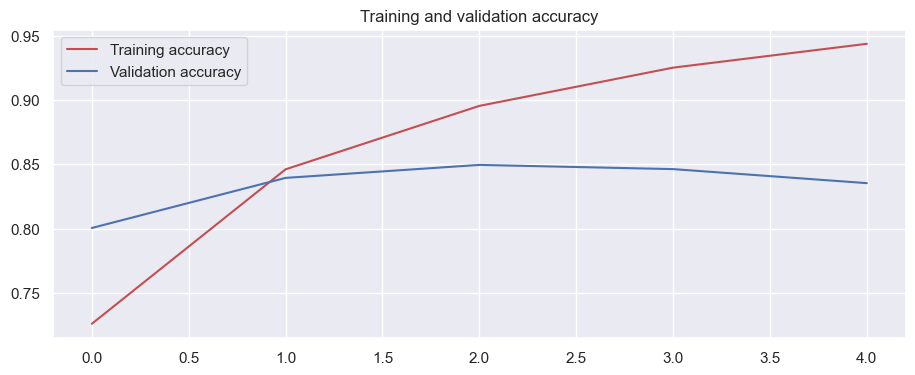

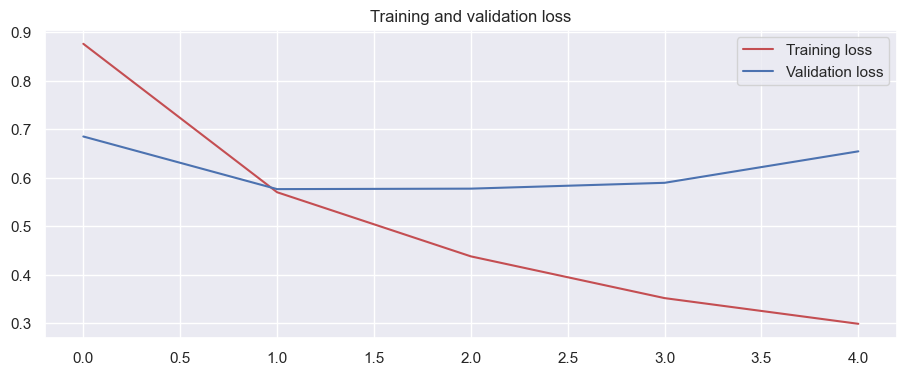

Accuracy on training data is:- 94.36570405960083 %
Loss 29.86362874507904
Accuracy on validation data is:- 83.53970646858215 %
Loss 65.41916131973267


In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.show()

print(f"Accuracy on training data is:- {acc[-1]*100} %")
print(f"Loss {loss[-1]*100}")

print(f"Accuracy on validation data is:- {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]*100}")

In [37]:
model.save("COVID_NLP5.keras")

In [38]:
joblib.dump(tokenizer, 'tokenizer5.joblib')

['tokenizer5.joblib']